In [1]:
%load_ext autoreload
%autoreload 2

import os.path
import pandas as pd
import numpy as np
import time
from datetime import timedelta
import tensorflow as tf
import json
from loadData import loadData, convertToBatches
from RNN import RNN, ExitCriteria, Parameters, Directories

import logging
logging.basicConfig(filename='train.log', level=logging.DEBUG)
logger = logging.getLogger(__name__)

inputDir = "GEFCom2012/"
logger.warn("Start Doing")

In [2]:
modelDirectory = "GEFCom2012/Model"
summaryDirectory = "GEFCom2012/Model"
maxGradient = 1
timeSteps = 24
nHorizons = 24
batchSize = 1
nHiddenUnits = 300
nLayers = 3
init = 0.05
inputSize = 1
keepProbability = 0.5
maxEpochs=1
learningRate=1.0
maxIterations = 1000000
loggingInterval = 100

In [3]:
#Train
trainingDfs, completeDfs = loadData("GEFCom2012/", maxDataPoints = -1)
ts = trainingDfs[0][["zone.1"]].values
batches = convertToBatches(ts, timeSteps, batchSize, nHorizons)


ts = trainingDfs[0][["zone.1"]].values
tsTest = completeDfs[0][["zone.1"]].values
tsTest = tsTest[len(ts):]
##Normalize ts
tsMean = ts.mean()
tsRange = ts.max()-ts.min()
ts = (ts-tsMean)/tsRange
tsTest = (tsTest-tsMean)/tsRange
if modelDirectory is None:
    logger.warn("Not saving a model.")
logger.info("Start Experiment")

# Run training.
start_time = time.time()
with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        model = RNN(maxGradient = maxGradient, 
                    timeSteps = timeSteps, 
                    nHorizons = nHorizons, 
                    inputSize = inputSize, 
                    nHiddenUnits = nHiddenUnits, 
                    nLayers = nLayers)
        with tf.Session() as session:
            tsTarget, tsFit, lastState = model.train(session = session, 
                        init = init, 
                        ts = ts, 
                        parameters = Parameters(learningRate, keepProbability, batchSize), 
                        exitCriteria = ExitCriteria(maxIterations, maxEpochs), 
                        validation = None, 
                        loggingInterval = loggingInterval, 
                        directories = Directories(modelDirectory, summaryDirectory),
                        logger = logger)
logger.info("Total training time %s" % timedelta(seconds=(time.time() - start_time)))



In [4]:
# Test
with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        with tf.Session() as session:
            model = RNN.restore(session, modelDirectory)
            tsTarget, tsPredicted, epoch_cost = model.predict(session = session,
                                                              startState = lastState, 
                                                              tsTest = tsTest,
                                                              batchSize = 1)

0.0762549683488


0.1594985383344773

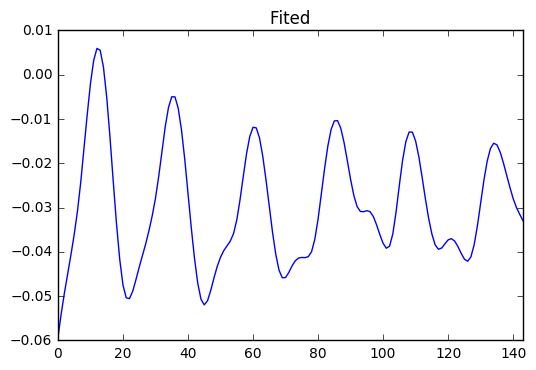

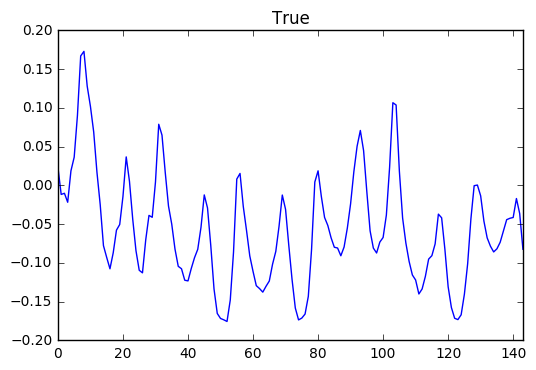

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline  
print np.sqrt(np.mean(np.square(tsTarget[:, 0]-tsPredicted[:, 0])))
x = pd.Series(tsPredicted[:, 0])
y = pd.Series(tsTarget[:, 0])
x.plot(title="Fited")
plt.figure()
y.plot(title="True")

x = x*tsRange+tsMean
y = y*tsRange+tsMean
np.mean(np.abs(x-y)/y)